In [23]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms



#### Setting device (checking if gpu is available for faster training)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Loading the dataset

In [25]:
import torchvision

def load_cifar10(batch_size):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    trans = transforms.Compose(trans)
    train = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=trans, download=True)
    test = torchvision.datasets.CIFAR10(
        root="../data", train=False, transform=trans, download=True)
    return (DataLoader(train, batch_size, shuffle=True, pin_memory=False),
            DataLoader(test, batch_size, shuffle=False, pin_memory=False))



In [26]:
BATCH_SIZE = 64
train_iter, test_iter = load_cifar10(BATCH_SIZE)
for data in train_iter:
    print(data[0].size())
    print(data[1].size())
    break

Files already downloaded and verified
Files already downloaded and verified
torch.Size([64, 3, 32, 32])
torch.Size([64])


### CIFAR-10 Dataset Analysis
Cifar-10 holds images if dimension 32x32
Cifar images also contain colour using the rgb format
Therefore each item in the dataset is of size 3x32x32


In [27]:
from torch import Tensor


class Model(torch.nn.Module):
    def __init__(self, in_channels, out_features):
        super(Model, self).__init__()
        # 2 Blocks then 3 linear layers
        B1_OUT = 10
        B2_OUT = 30
        L1_OUT = 4000
        L2_OUT = 500

        
        self.block1 = Block(3,in_channels,out_channels=B1_OUT)
        self.block2 = Block(5,B1_OUT,B2_OUT, kernel_size=4,stride=2)
        
        # Linear Layers
        # given b1 -> c x 32 x 32
        # given b2 -> c x 17 x 17 (b2 kernel = 4, stride = 2)
        self.Sigmoid = nn.Sigmoid()
        self.linear1 = nn.Linear(B2_OUT*17*17,L1_OUT)
        self.linear2 = nn.Linear(L1_OUT,L2_OUT)
        self.linear3 = nn.Linear(L2_OUT, out_features)

    def forward(self, x):
        # [batchsize, 3, 32, 32]
        out: Tensor = self.block1(x)
        # [batchsize, 10, 32, 32]
        out = self.Sigmoid(out)
        
        # [batchsize, 10, 32, 32]
        out = self.block2(out)
        # [batchsize, 30, 17, 17]
        out = self.Sigmoid(out)


        # flatten for linear layers
        # print(out.size())
        out = out.reshape(-1 , 30*17*17)
        out = self.linear1(out)
        out = self.Sigmoid(out)
        
        out = self.linear2(out)
        out = self.Sigmoid(out)
        
        out = self.linear3(out)
        
        
        return out


class Block(torch.nn.Module):
    def __init__(self, k, in_channels, out_channels, padding=2, kernel_size=5, stride=1):
        super(Block, self).__init__()
        self.k = k
        self.out_channels = out_channels
        self.in_channels = in_channels
        
        # defining weight calculations (a)
        
        
        self.spatialAvgPool = nn.AdaptiveAvgPool2d(1)
        # flatten
        self.aLinear1 = nn.Linear(in_features=in_channels, out_features=k) 
        self.Sigmoid = nn.Sigmoid()
        
        # ===============temp
        self.TEMP = nn.Linear(in_features=5120, out_features=10)
        # ===============temp
        
        # defining the convolution section
        
        # creates k convolutions
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size ,padding=padding, stride=stride) for _ in range(k)])
        

    def forward(self, x: Tensor) -> Tensor:
        
        # apply spatial average pooling
        pooled: Tensor = self.spatialAvgPool(x)
        # flatten the output for the linear layer
        pooled = pooled.view(pooled.size(0), -1)
        a: Tensor = self.Sigmoid(self.aLinear1(pooled)) # creates vector of size k
        
        O: Tensor = torch.zeros_like(self.convs[0](x))
        
        # Apply the convolutions and accumulate the weighted sum
        for i in range(self.k):
            O = O + a[:, i].view(-1, 1, 1, 1) * self.convs[i](x) # this calculates a_1 conv_1 + ... + a_k conv_k
        
        # O = O.reshape(-1, 5120) # 5 x 32 x 32 , 
        # O = self.TEMP(O)
        
        if not isinstance(O, torch.Tensor):
            raise TypeError(f"Expected O to be a torch.Tensor but got {type(O)}")

        return O # returns [batchsize, c, h, w]
        

### Training The Model

In [28]:
class Accumulator:
    
    def __init__(self, n) -> None:
        self.data = [0.0] * n
    
    # deletes all data and information stored
    def reset(self) -> None:
        self.data = [0.0] * len(self.data)
    
    # takes in n inputs, for each arg it adds it to its corresponding index in data
    def add(self, *args) -> None:
        self.data = [a + float(b) for a,b in zip(self.data, args)]
    
    # allows the indexing operator to be used
    def __getitem__(self, idx) -> any:
        return self.data[idx]
    
    def toList(self) -> list:
        return self.data
    
    def percentage(self, index, total):
        return 100 * self[index] / total if total > 0 else 0

In [29]:
import matplotlib.pyplot as plt

def trainingLoop(num_epoch, train_iter, test_iter, net, loss_function, optimizer):
    loss_values = [] 
    training_accuracy_values = []  
    testing_accuracy_values = []

    for epoch in range(num_epoch):
        # train on trianing set to obtain updated weights
        train_metrics = train(train_iter, net, loss_function, optimizer) # tuple (loss , accuracy)
        # testing new weights on unseen data
        test_accuracy = test(test_iter, net)
        # data for plotting
        loss_values.append(train_metrics[0])
        training_accuracy_values.append(train_metrics[1]) 
        testing_accuracy_values.append(test_accuracy)

        print(f'Epoch {epoch+1}, Average Loss: {loss_values[-1]}, Training Accuracy: {training_accuracy_values[-1]}, Testing Accuracy {testing_accuracy_values[-1]}')
        
    return(num_epoch, loss_values, training_accuracy_values, testing_accuracy_values)


def test(data_iter, net):
    net.eval() # set to testing mode
    
    metrics = Accumulator(2) # [correct, total]
    
    with torch.no_grad():
        for X, y in data_iter:
            # Move data to the specified device
            X, y = X.to(device), y.to(device)
            # Get model predictions
            y_hat = net(X)
            # Convert probabilities to predicted class labels
            _, predicted_labels = torch.max(y_hat, 1)
            # Accumulate the number of correct predictions and the total
            metrics.add((predicted_labels == y).sum().item(), y.size(0))
    
    # Calculate accuracy
    accuracy = metrics[0] / metrics[1]
    
    # Set the network back to training mode
    net.train()
    
    return accuracy

def train(data_iter, net, loss_function, optimizer):
    net.train()
    
    metrics = Accumulator(3)  # [sum of losses, correct predictions, total predictions]
    for X, Y in data_iter:  # get x and corresponding y value
        X, Y = X.to(device), Y.to(device)
        
        y_hat = net(X)  # get prediction
        loss = loss_function(y_hat, Y)  # loss of this specific value
        optimizer.zero_grad()  # clear gradient
        loss.backward()  # calculate derivative of loss w.r.t the weight
        optimizer.step()  # change weight values accordingly

        metrics.add(loss.item(), (torch.max(y_hat, 1)[1] == Y).float().sum().item(), Y.size(0))
    # Calculate average loss and accuracy from the accumulated values
    avg_loss = metrics[0] / metrics[2]
    accuracy = metrics[1] / metrics[2]
    
    return (avg_loss, accuracy)


In [30]:
# Function to plot the data
def plotTraining(num_epoch, loss_values, train_accuracy_values, test_accuracy_values):
    fig, ax1 = plt.subplots()

    # Training Loss
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color=color)
    ax1.plot(range(1, num_epoch+1), loss_values, '-o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis to share the same x-axis
    ax2 = ax1.twinx()  

    # Training Accuracy and Testing Accuracy
    color_train = 'tab:blue'
    color_test = 'tab:green'
    ax2.set_ylabel('Accuracy', color=color_train)  # We already handled the x-label with ax1
    # Plot training accuracy on ax2
    ax2.plot(range(1, num_epoch+1), train_accuracy_values, '-s', color=color_train, label='Train Accuracy')
    # Plot testing accuracy on ax2 as well
    ax2.plot(range(1, num_epoch+1), test_accuracy_values, '-^', color=color_test, label='Test Accuracy')
    ax2.tick_params(axis='y', labelcolor=color_train)
    ax2.legend(loc='upper left')

    fig.tight_layout()  # Otherwise the right y-label is slightly clipped
    plt.title('Training Loss and Accuracy')
    plt.show()


In [31]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)


In [32]:

model = Model(3, 10).to(device)
# model = Model(3, 10)
model.apply(init_weights)

loss = nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# train_iter, test_iter = mu.load_data_fashion_mnist(256)

Epoch 1, Average Loss: 0.03619251421928406, Training Accuracy: 0.0993, Testing Accuracy 0.1
Epoch 2, Average Loss: 0.036168272562026975, Training Accuracy: 0.10108, Testing Accuracy 0.1
Epoch 3, Average Loss: 0.03615340784072876, Training Accuracy: 0.0986, Testing Accuracy 0.1
Epoch 4, Average Loss: 0.0361389750957489, Training Accuracy: 0.10204, Testing Accuracy 0.1
Epoch 5, Average Loss: 0.036138889288902284, Training Accuracy: 0.09866, Testing Accuracy 0.1
Epoch 6, Average Loss: 0.03611193830490112, Training Accuracy: 0.10014, Testing Accuracy 0.1
Epoch 7, Average Loss: 0.03610794978618622, Training Accuracy: 0.10104, Testing Accuracy 0.1
Epoch 8, Average Loss: 0.036089931178092956, Training Accuracy: 0.10304, Testing Accuracy 0.1
Epoch 9, Average Loss: 0.03606663640499115, Training Accuracy: 0.10408, Testing Accuracy 0.1135
Epoch 10, Average Loss: 0.036056229696273805, Training Accuracy: 0.10214, Testing Accuracy 0.1
Epoch 11, Average Loss: 0.036006497287750246, Training Accuracy: 

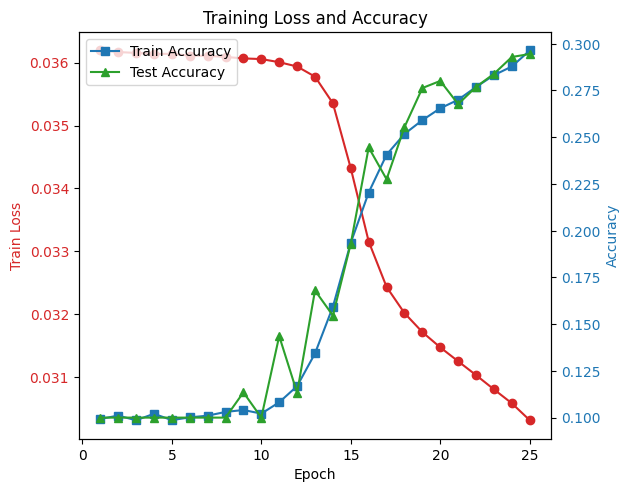

In [33]:
num_epochs = 100
# mu.train_ch3(model, train_iter, test_iter, loss, num_epochs, optimizer)
params = trainingLoop(num_epochs,train_iter,test_iter ,model, loss, optimizer)
plotTraining(*params) # spreads tuple
# Epoch 1, Average Loss: 0.03618157117366791, Training Accuracy: 0.09968, Testing Accuracy 0.1